In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

In [2]:
aapl = pdr.get_data_google('AAPL', '2012-08-01', '2017-01-01')

In [3]:
aapl.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-08-01,87.99,88.06,86.14,86.69,96124742
2012-08-02,86.12,87.24,85.75,86.83,83062203
2012-08-03,87.66,88.28,87.37,87.96,86228604
2012-08-06,88.18,89.27,87.89,88.94,75580008
2012-08-07,88.97,89.29,88.29,88.70,72627492


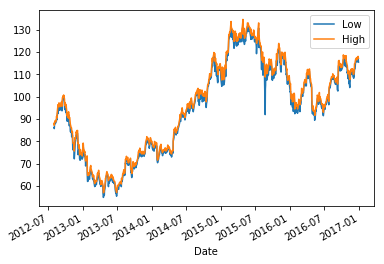

In [4]:
aapl[['Low', 'High']].plot()

In [5]:
symbols = ['SPY', 'GOOG', 'IBM', 'GLD']

In [6]:
df = pd.DataFrame()
for symbol in symbols:
    df_temp = pdr.get_data_google(symbol, '2010-01-01', '2012-01-01')
    df_temp.rename(columns={'Close': symbol}, inplace=True)
    df = df.join(df_temp[symbol], how='outer')
df.head()

,SPY,GOOG,IBM,GLD
Date,,,,
2010-01-04,113.33,313.06,132.45,109.80
2010-01-05,113.63,311.68,130.85,109.70
2010-01-06,113.71,303.83,130.00,111.51
2010-01-07,114.19,296.75,129.55,110.82
2010-01-08,114.57,300.71,130.85,111.37


In [7]:
df['GOOG']['2010-01-04':'2010-01-10']

Date
2010-01-04    313.06
2010-01-05    311.68
2010-01-06    303.83
2010-01-07    296.75
2010-01-08    300.71
Name: GOOG, dtype: float64

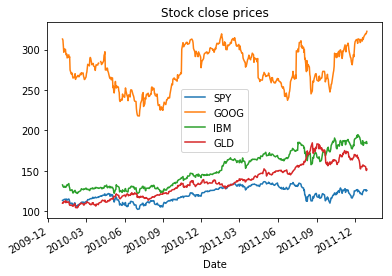

In [8]:
df.plot(title='Stock close prices')

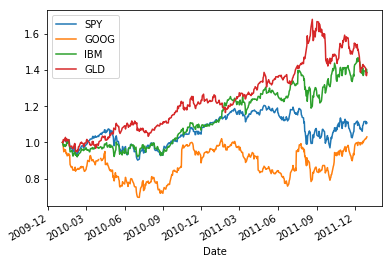

In [9]:
(df/df.iloc[0, :]).plot()

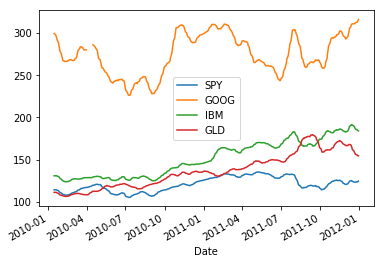

In [10]:
df.rolling(window=10).mean().plot()

# Returns

In [11]:
daily_ret = df.pct_change(1)
cumulative_ret = (df/df.iloc[0,:]-1)

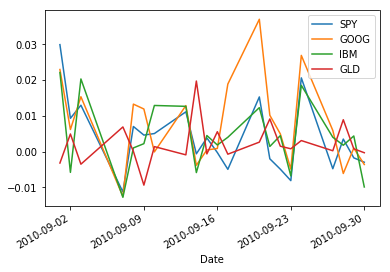

In [12]:
daily_ret['2010-9'].plot()

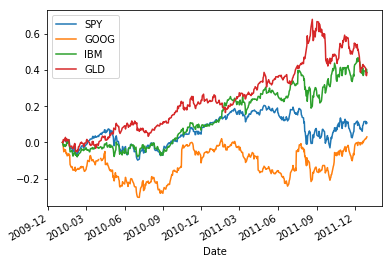

In [13]:
cumulative_ret.plot()

# Missing data
* Fill forward
* Fill backward

In [14]:
missing_df = df.copy()
missing_df.loc['2011-01-01': '2011-04-01'] = np.NaN
missing_df.loc[:'2010-03'] = np.NaN

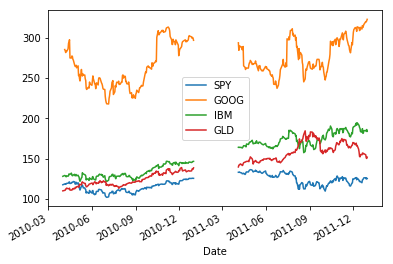

In [15]:
missing_df.plot()

In [16]:
missing_df.fillna(method='ffill', inplace=True)
missing_df.fillna(method='bfill', inplace=True)

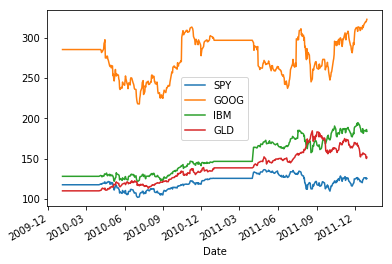

In [17]:
missing_df.plot()

# Plotting

In [18]:
mean = daily_ret['SPY'].mean()
std_dev = daily_ret['SPY'].std()
kurtosis = daily_ret.kurtosis()

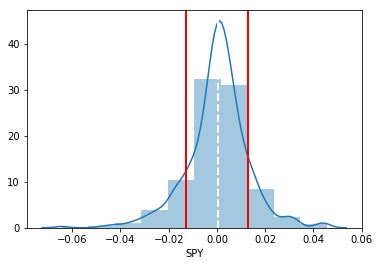

In [19]:
ax = sns.distplot(daily_ret['SPY'].dropna(), bins=10)
ax.axvline(mean, color='w', linestyle='dashed', linewidth=2)
ax.axvline(std_dev, color='r', linewidth=2)
ax.axvline(-std_dev, color='r', linewidth=2)

In [20]:
kurtosis

SPY     2.665349
GOOG    9.688734
IBM     2.163084
GLD     1.883208
dtype: float64

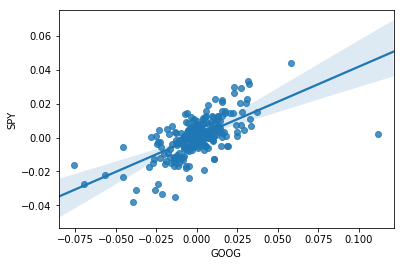

In [21]:
sns.regplot(data=daily_ret.loc['2010'], x='GOOG', y='SPY', marker='o')

---
# Portfolio
* start value (10000)
* start date
* end date
* ticker list
* allocs (0.4, 0.4, 0.15, 0.05)

### Daily portfolio value and portfolio statistics

End value: 113263.871714

Cumulative return over the whole period (buy and hold):
0.13263871713739928

Avg:
SPY     0.000287
GOOG    0.000222
IBM     0.000734
GLD     0.000715
dtype: float64

Std:
SPY     0.012939
GOOG    0.018079
IBM     0.012785
GLD     0.011724
dtype: float64

Sharpe ratio:
SPY     0.496824
GOOG    0.275424
IBM     1.287717
GLD     1.368696
dtype: float64


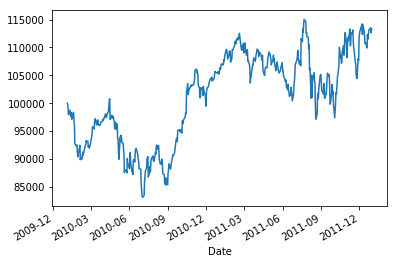

In [22]:
def calc_and_plot_portfolio_value(weights, start_value=100000):
    normed = (cumulative_ret+1).dropna()
    alloced = normed*weights
    pos_vals = alloced*start_value
    portfolio_val = pos_vals.sum(axis=1)
    portfolio_val.plot()
    print('End value:', str(portfolio_val.iloc[-1]))
    cumret = portfolio_val.iloc[-1]/portfolio_val.iloc[0]-1
    avg_daily_ret = daily_ret.mean()
    std_daily_ret = daily_ret.std()
    print(f'\nCumulative return over the whole period (buy and hold):\n{cumret}\n\nAvg:\n{avg_daily_ret}\n\nStd:\n{std_daily_ret}')
    sharpe_ratio = np.sqrt(len(portfolio_val)) * avg_daily_ret / std_daily_ret
    print(f'\nSharpe ratio:\n{sharpe_ratio}')
    
calc_and_plot_portfolio_value(np.array([0.4, 0.4, 0.15, 0.05]))

---
# Optimizers

In [23]:
import scipy.optimize as spo

In [24]:
def f(X):
    Y = (X-1.5)**2 + 0.5
    print(f'X = {X}, Y = {Y}')
    return Y

In [25]:
min_res = spo.minimize(f, 2.0, method='SLSQP', options={'disp': True})
print(f'Minima found at: {min_res.x}, result: {min_res.fun}')

X = [ 2.], Y = [ 0.75]
X = [ 2.], Y = [ 0.75]
X = [ 2.00000001], Y = [ 0.75000001]
X = [ 0.99999999], Y = [ 0.75000001]
X = [ 1.5], Y = [ 0.5]
X = [ 1.5], Y = [ 0.5]
X = [ 1.50000001], Y = [ 0.5]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5
            Iterations: 2
            Function evaluations: 7
            Gradient evaluations: 2
Minima found at: [ 1.5], result: 0.5


In [26]:
def calc_sharpe(daily_ret):
    avg_daily_ret = daily_ret.mean()
    std_daily_ret = daily_ret.std()
    multi = np.sqrt(len(daily_ret))
    return multi*(avg_daily_ret/std_daily_ret)

In [27]:
def portfolio(weights, data):
#     print('Weights\n', str(weights))
    daily_ret = data.pct_change()
    sharpe_weighted = calc_sharpe(daily_ret)*weights
#     print(sharpe_weighted.prod())
    return -1 * sharpe_weighted.sum()

In [28]:
bnds = tuple((0.1, 0.5) for i in range(4))
bnds

((0.1, 0.5), (0.1, 0.5), (0.1, 0.5), (0.1, 0.5))

In [29]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

In [30]:
initial = np.ones(4)*0.25

In [31]:
result = spo.minimize(portfolio, initial, args=(df,), method='SLSQP', bounds=bnds, constraints=cons, options={'disp': True}) #  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.1490284701900317
            Iterations: 4
            Function evaluations: 24
            Gradient evaluations: 4


In [32]:
result

     fun: -1.1490284701900317
     jac: array([-0.497318  , -0.27569792, -1.28899667, -1.37005576])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.1,  0.1,  0.3,  0.5])

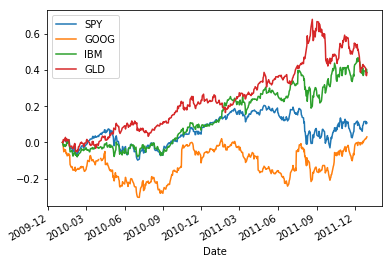

In [33]:
cumulative_ret.plot()

End value: 122762.407055

Cumulative return over the whole period (buy and hold):
0.22762407054645029

Avg:
SPY     0.000287
GOOG    0.000222
IBM     0.000734
GLD     0.000715
dtype: float64

Std:
SPY     0.012939
GOOG    0.018079
IBM     0.012785
GLD     0.011724
dtype: float64

Sharpe ratio:
SPY     0.496824
GOOG    0.275424
IBM     1.287717
GLD     1.368696
dtype: float64


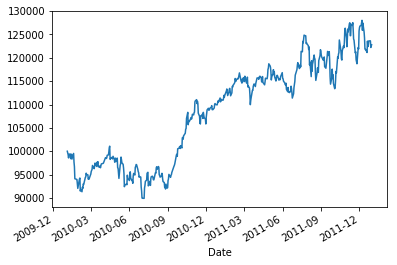

In [34]:
calc_and_plot_portfolio_value(initial)

End value: 132240.675443

Cumulative return over the whole period (buy and hold):
0.32240675442560307

Avg:
SPY     0.000287
GOOG    0.000222
IBM     0.000734
GLD     0.000715
dtype: float64

Std:
SPY     0.012939
GOOG    0.018079
IBM     0.012785
GLD     0.011724
dtype: float64

Sharpe ratio:
SPY     0.496824
GOOG    0.275424
IBM     1.287717
GLD     1.368696
dtype: float64


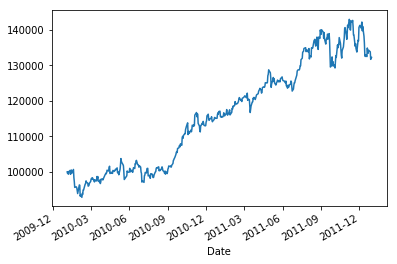

In [35]:
calc_and_plot_portfolio_value(result.x)

---
# Funds
* Types:
  * ETF: basket of stocks, can be traded daily, liquid, high volume
    * S&P 500 -> SPY
  * Mutual Fund: EOD buy/sell, net asset value computation, quarterly disclosure, stated goals (large capitalization stocks)
  * Hedge Fund: agreement based, closed informations
* AUM: Assets Under Management
  * ETF: 0.01% + 1% compensation
  * MF: 0.5% + 3% compensation
  * HF: 2% + 20% compensation

---
# Orders
* Bus/Sell
* Symbol
* #shares
* Limit or Market
* Price
 * BUY IBM 100 LIMIT 99.95
 * SELL GOOG 200 MARKET

Order book: used to put every living orders in.